In [1]:
# import _imports
from typing import (List, Tuple, Dict, Callable, Union)

import pandas as pd
import numpy as np

import get_dataset

import warnings

warnings.filterwarnings("ignore")

# 数据获取

In [3]:
# 数据获取
get_dataset.get_data('all')

数据获取(起始日:2013-01-01,结束日:2022-02-28
开始划分高低端象限...


高低端象限数据获取完毕!
开始划分四象限...


四象限数据获取完毕!
开始获取因子数据...


因子数据获取完毕!
开始获取收盘价数据...


收盘价数据获取完毕!


# 读取数据

In [2]:
dichotomy, quandrant, factors_frame, pricing = get_dataset.load_data()

dichotomy.csv文件读取完毕!
quandrant_df.csv文件读取完毕!
factors_frame.csv文件读取完毕!
pricing.csv文件读取完毕!


# 因子分析

## 高低端因子分析

In [3]:
from analyze_func import get_factor_res
from plotting import plotting_dichotomy_res
from my_scr import (quadrant_dic, dichotomy_dic)

In [8]:
# 获取roe高端/低端,营收高端/低端的数据
res = get_factor_res(dichotomy,
                     factors_frame,
                     pricing,
                     dichotomy_dic,
                     group_num=3)

可以看到低ROE端因子单调性都较好

- ILLIQ_20D:第三组（高分组）收益较好，但IC较低为1.79%(分组中最低,较为异常)；
- RealizedSkewness_240D:第一组(低分组)收益较好,IC为3.05%(分组中最高)；
- VolAvg_20D_240D:第一组(低分组)收益较好,IC为-0.34%(分组中最低,较为异常)；
- VolCV_20D:第一组(低分组)收益较好,IC为-2.63%(分组中最高)；



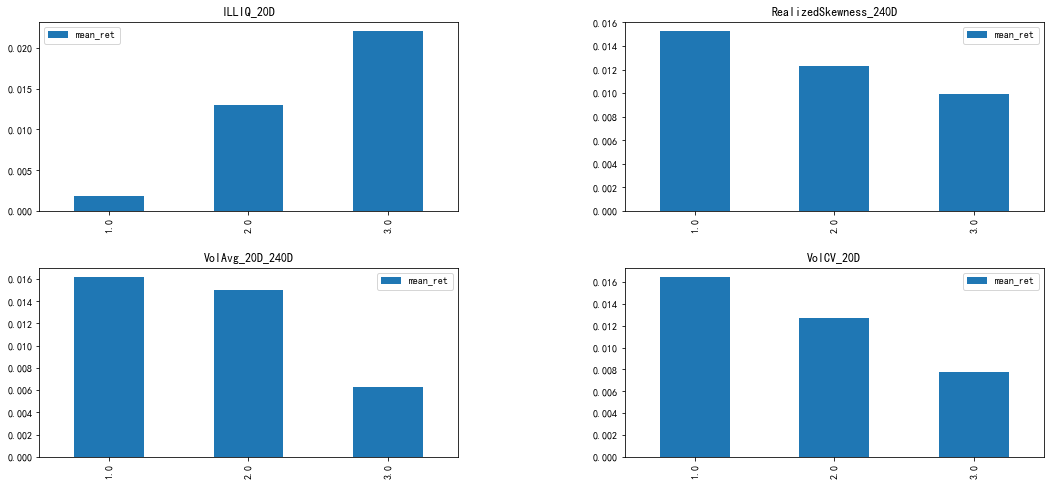

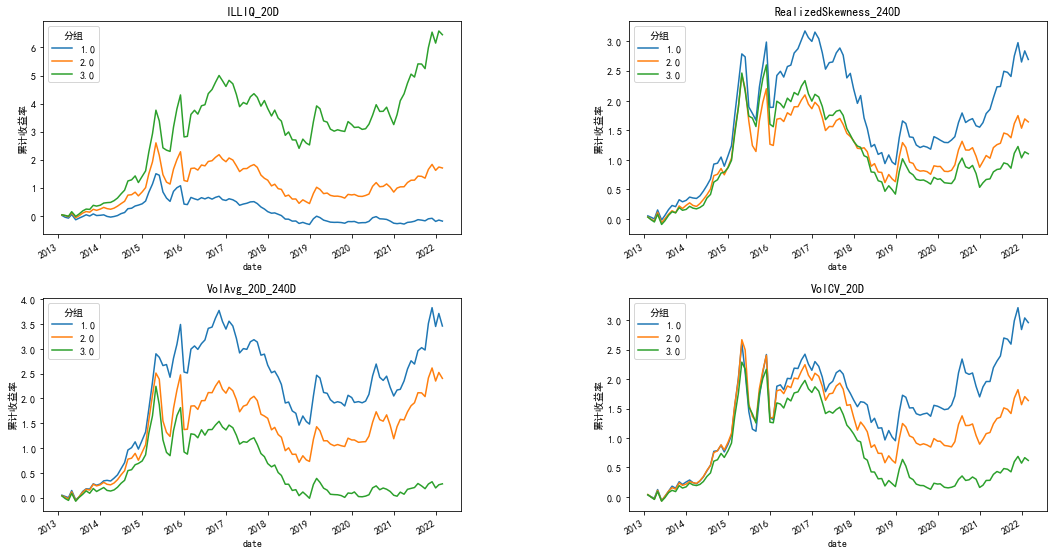

In [10]:
plotting_dichotomy_res(res['低ROE端'])

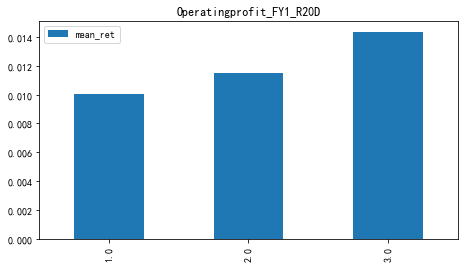

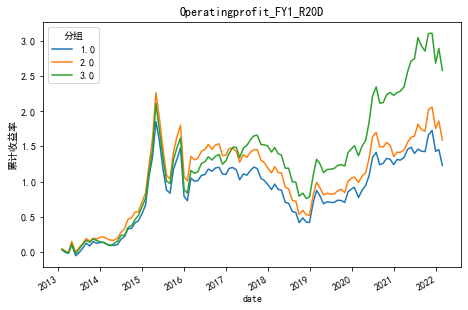

In [11]:
plotting_dichotomy_res(res['高ROE端'])

低增长端因子单调性较好
- Gross_profit_margin_chg:第三组收益较高(高分组),IC为-1.27%(分组中最低,较为异常);
- Netprofit_chg:第三组收益较高(高分组),IC为-1.64%(分组绝对值最高);

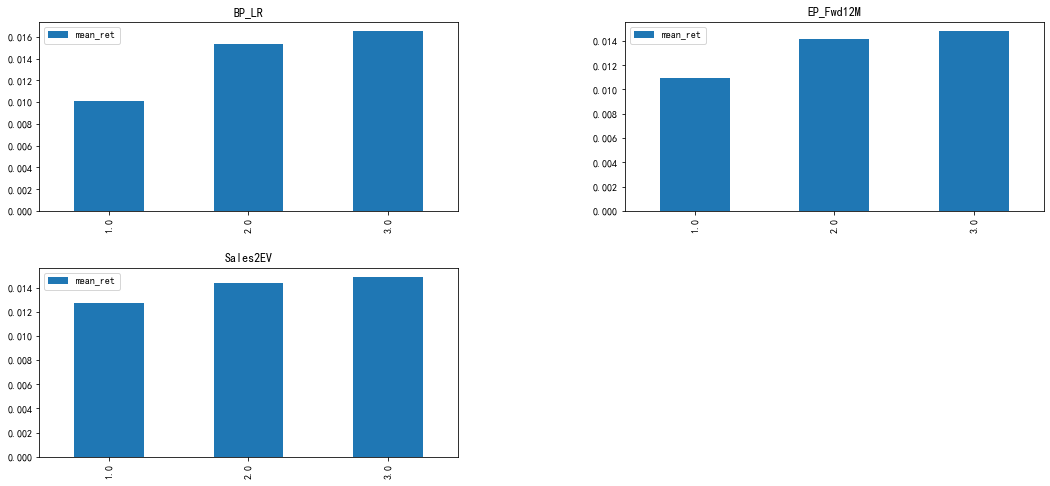

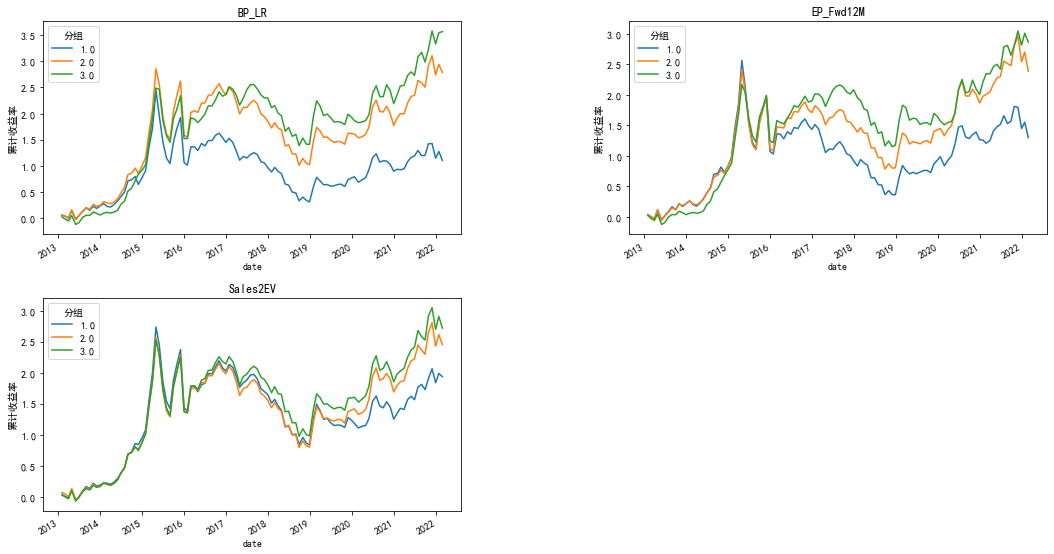

In [12]:
plotting_dichotomy_res(res['低增长端'])

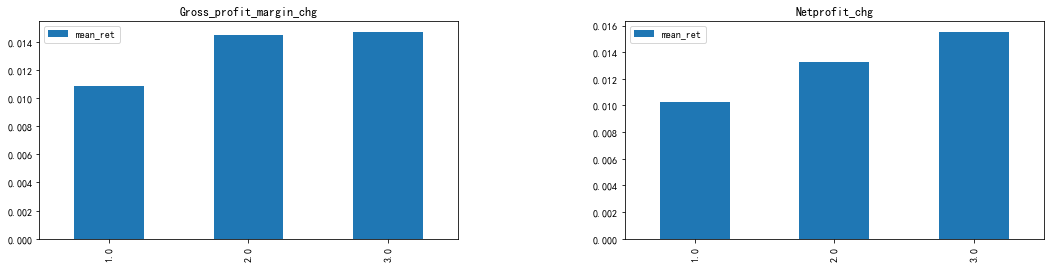

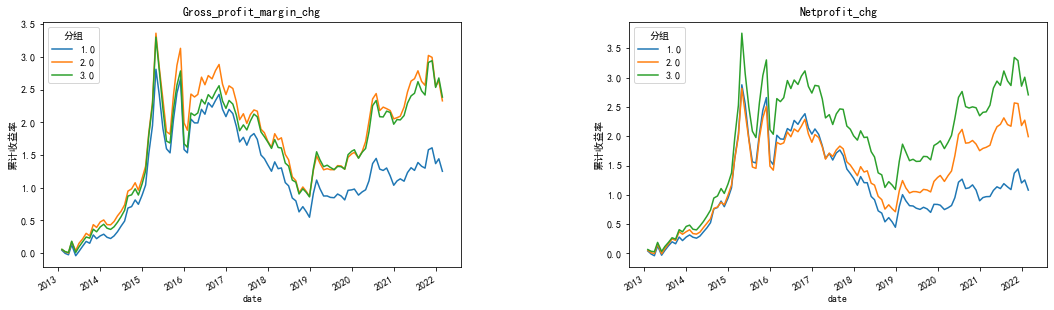

In [13]:
plotting_dichotomy_res(res['高增长端'])

## 四象限因子分析

In [6]:
import composition_factor as comp_factor
import alphalens as al
import empyrical as ep
from my_scr import (get_group_return, add_group)


In [5]:
# 1=>成长 一致预期+成长质量
factors1 = ( 'BP_LR', 'EP_Fwd12M', 'Sales2EV','ILLIQ_20D', 'RealizedSkewness_240D',
    'VolAvg_20D_240D', 'VolCV_20D')
   

direction1 = (
    'ascending', 'ascending', 'ascending', 'descending', 'descending',
    'descending', 'descending'
)
# 2=>导入 量价+成长质量
factors2 = ('BP_LR', 'EP_Fwd12M', 'Operatingprofit_FY1_R20D', 'Sales2EV')
direction2 = ('ascending', 'descending', 'ascending', 'ascending')

# 3=>衰退 量价指标+价值稳定
factors3 = [
    'Gross_profit_margin_chg', 'Netprofit_chg', 'Operatingprofit_FY1_R20D'
]
direction3 = ['ascending', 'ascending', 'ascending']

# 4=>成熟 一致预期+价值稳定
factors4 = [
    'Gross_profit_margin_chg', 'ILLIQ_20D', 'Netprofit_chg',
    'RealizedSkewness_240D', 'VolAvg_20D_240D', 'VolCV_20D'
]
direction4 = [
    'ascending', 'ascending', 'ascending', 'descending', 'descending',
    'descending'
]

direction = {
    name: dict(zip(k, v))
    for name, k, v in zip(('导入期', '成长期', '成熟期',
                           '衰退期'), (factors1, factors2, factors3,
                                    factors4), (direction1, direction2,
                                                direction3, direction4))
}


In [6]:
stack_quandrant = quandrant.stack().to_frame('cat_type')
res2 = get_factor_res(stack_quandrant,
                      factors_frame,
                      pricing,
                      quadrant_dic,
                      group_num=3,
                      direction=direction,
                      comp_params={'method':'maxic',
                                   'window':5,
                                   'is_rank':False})


### 导入期

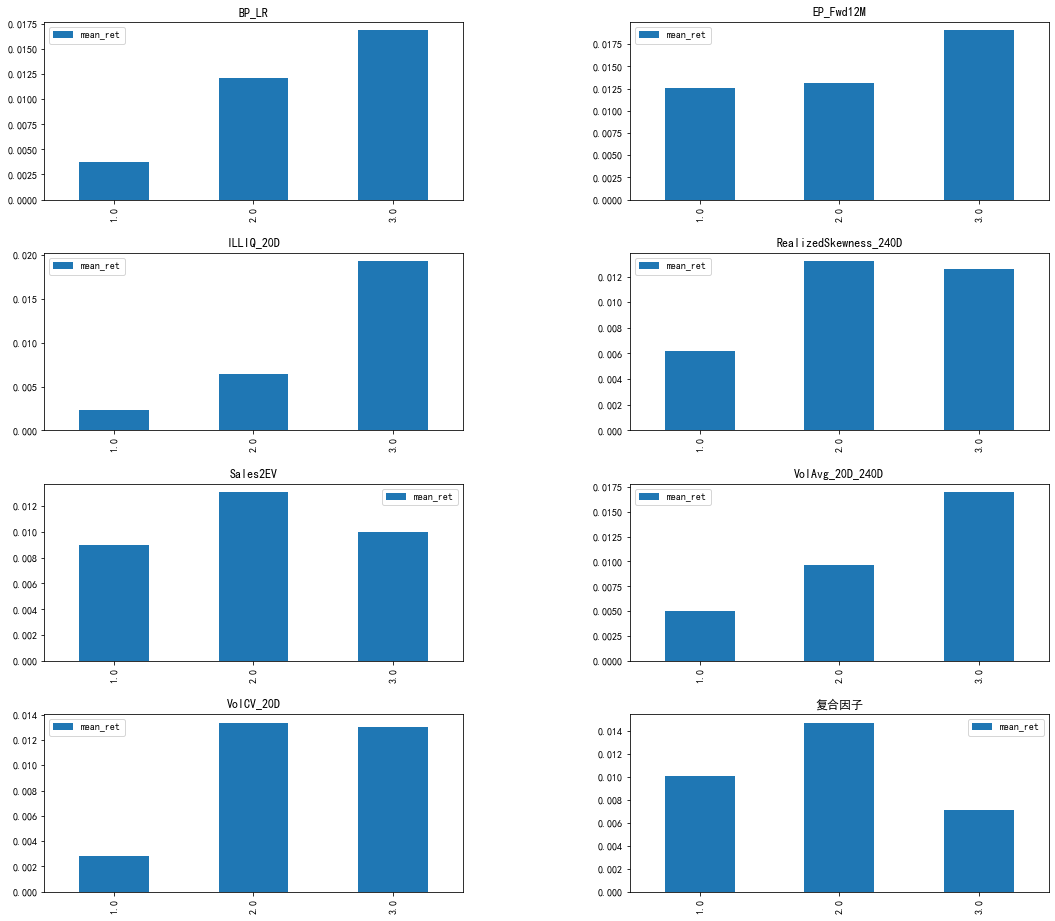

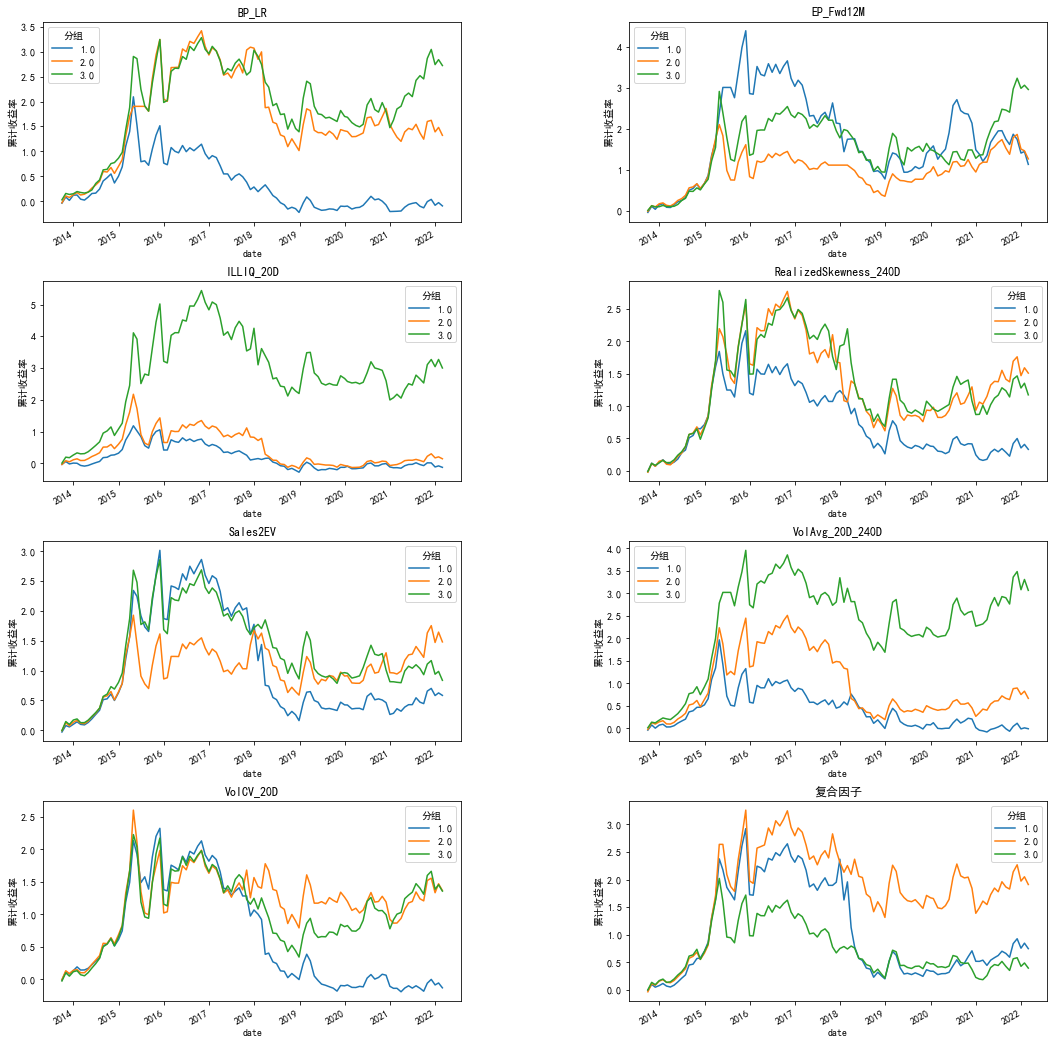

In [7]:
plotting_dichotomy_res(res2['导入期'])

### 成长期

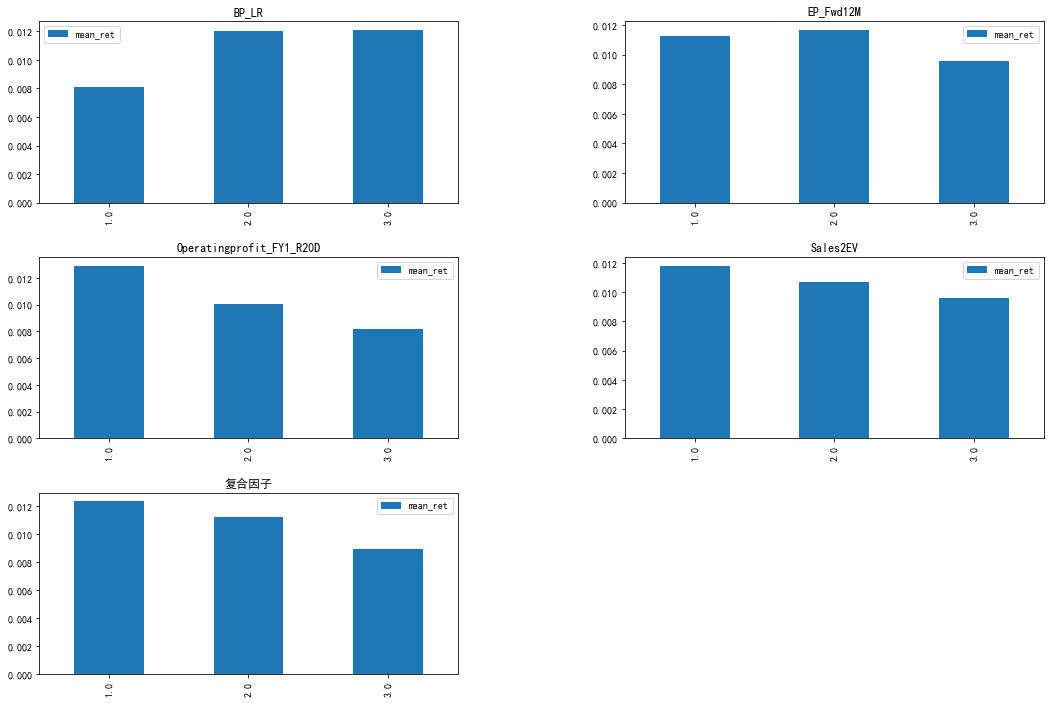

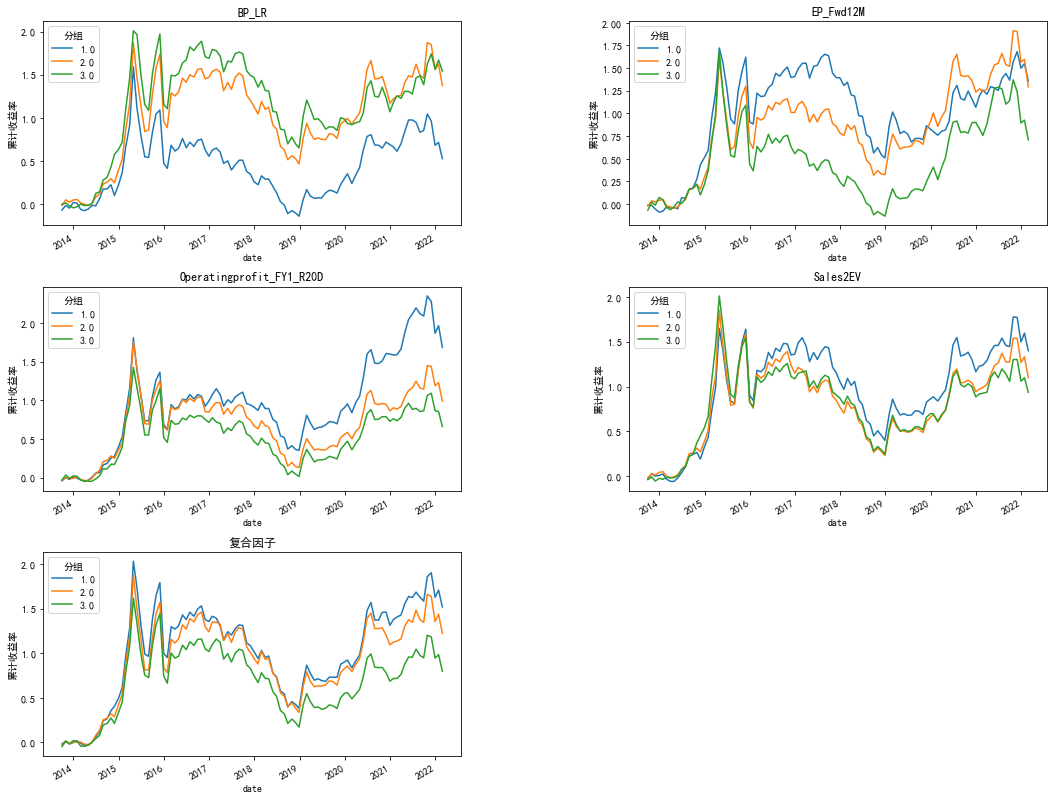

In [8]:
plotting_dichotomy_res(res2['成长期'])

### 成熟期

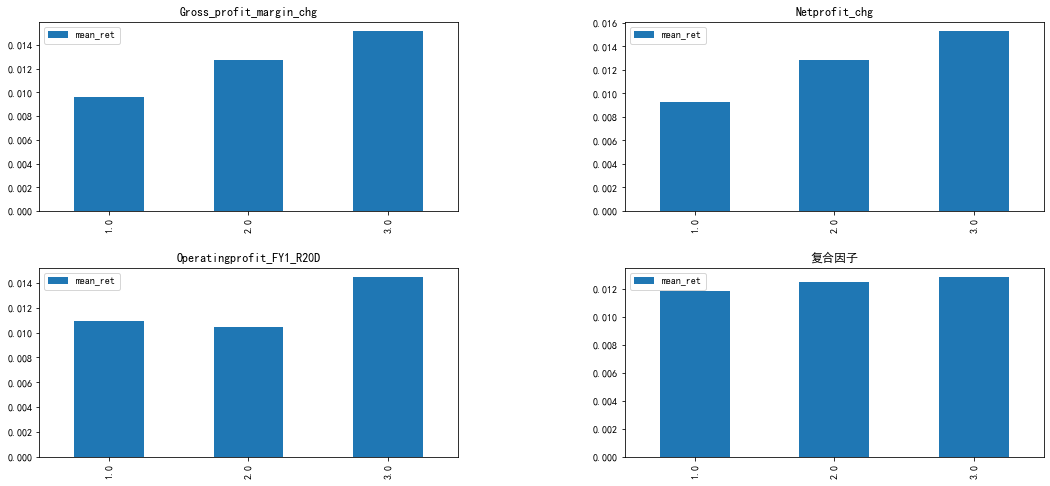

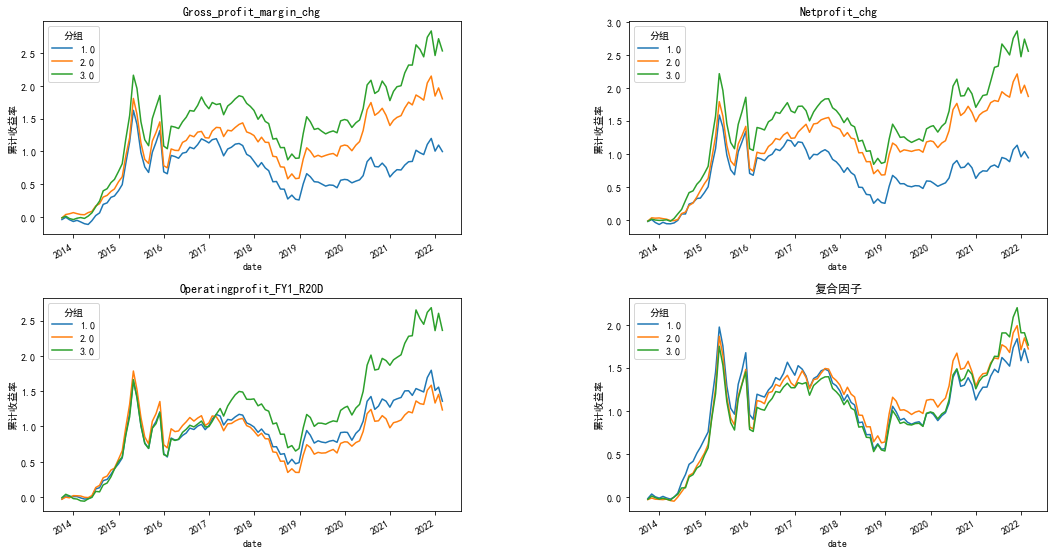

In [9]:
plotting_dichotomy_res(res2['成熟期'])

### 衰退期

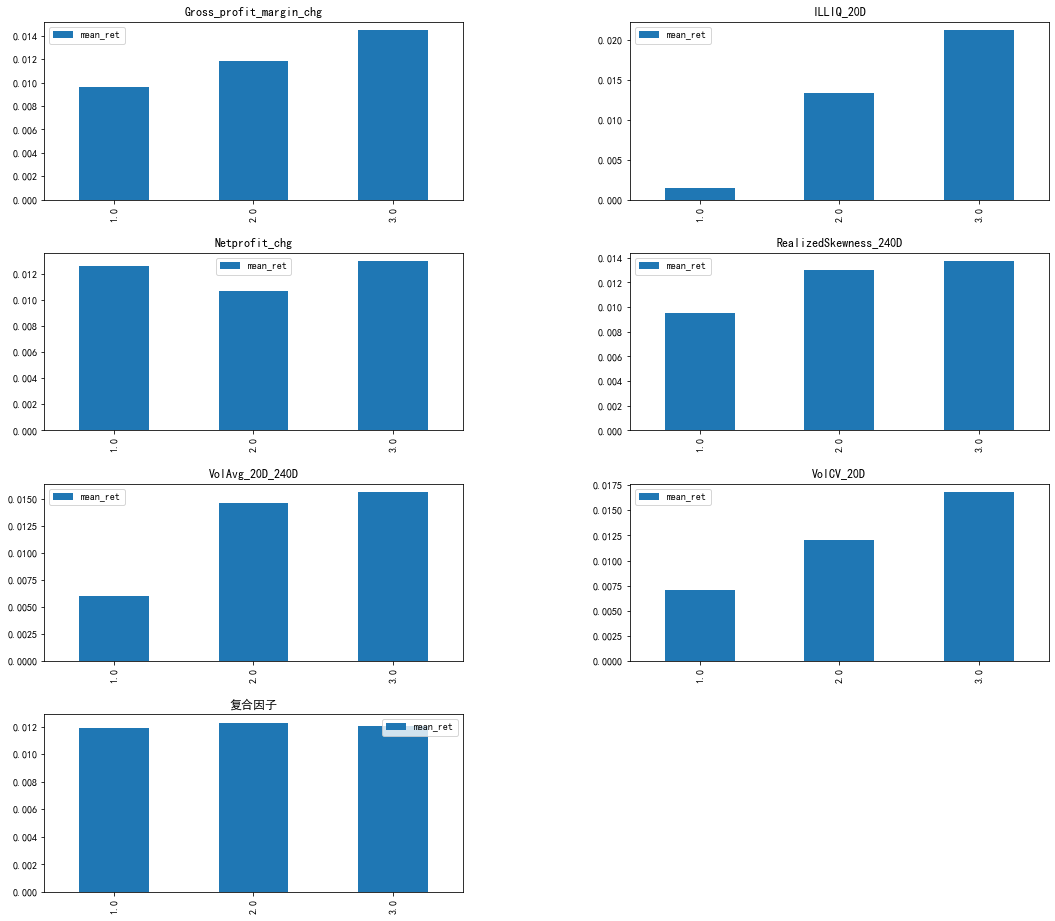

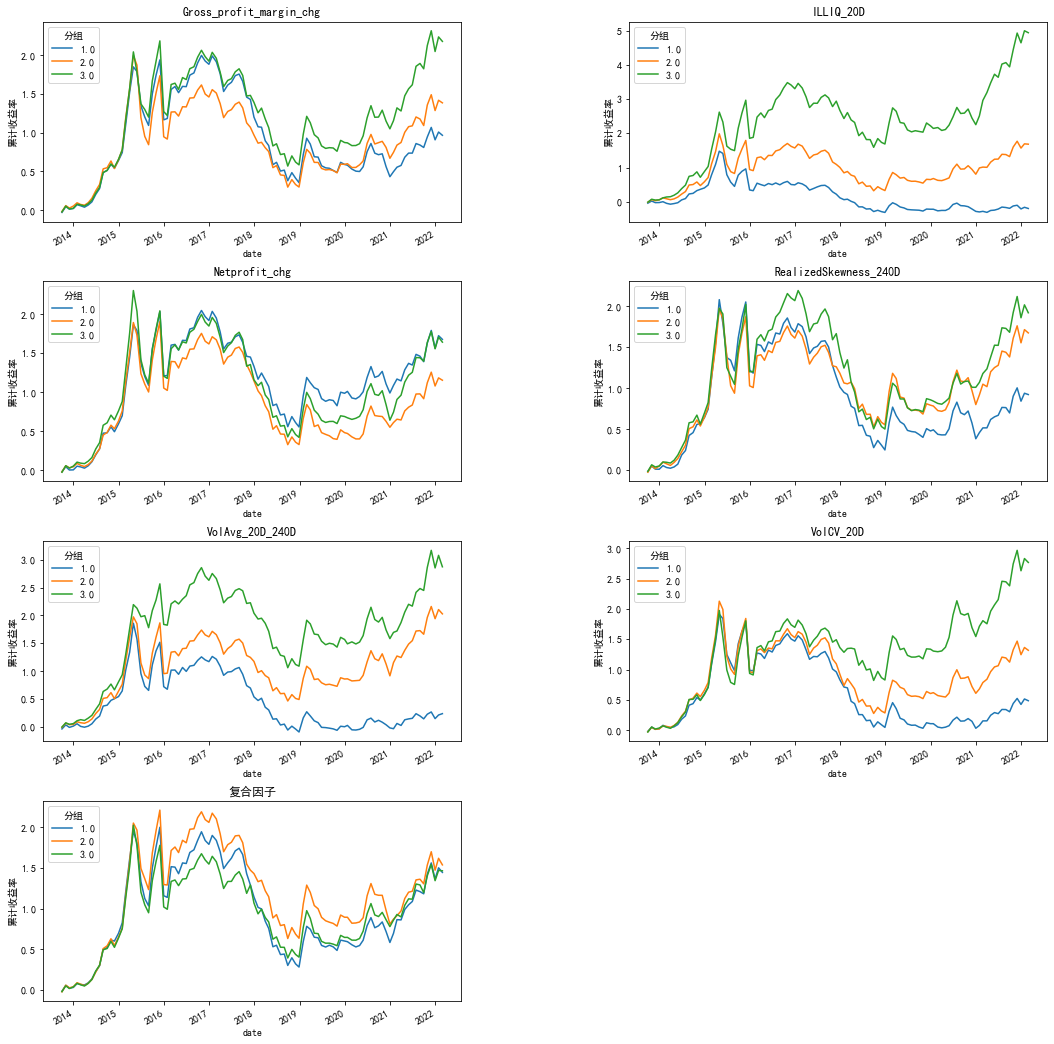

In [10]:
plotting_dichotomy_res(res2['衰退期'])

# 单独测试

In [8]:
factors = factors_frame.copy()
next_ret = comp_factor.compute_forward_returns(pricing, (1, ))
factors['next_ret'] = next_ret[1]

In [10]:
idx = stack_quandrant.query('cat_type==1').index
quandrant_factor1 = factors.loc[idx]

In [8]:
direction['成长期']

{'BP_LR': 'ascending',
 'EP_Fwd12M': 'descending',
 'Operatingprofit_FY1_R20D': 'ascending',
 'Sales2EV': 'ascending'}

In [31]:
score = comp_factor.factor_score_indicators(
    quandrant_factor1, 'maxicir_ledoit', {
        'BP_LR': 'ascending',
        'EP_Fwd12M': 'descending',
        'Operatingprofit_FY1_R20D': 'ascending',
        'Sales2EV': 'ascending'
    }, 5)


In [32]:
add_group(score, 'score', 3)

score
date                         
2013-09-30 000001.XSHE      1
           000002.XSHE      3
           000008.XSHE      1
           000011.XSHE      1
           000024.XSHE      1
...                       ...
2022-02-28 688777.XSHG      2
           688788.XSHG      3
           688819.XSHG      1
           688981.XSHG      1
           689009.XSHG      1

[74690 rows x 1 columns]

<AxesSubplot:xlabel='date'>

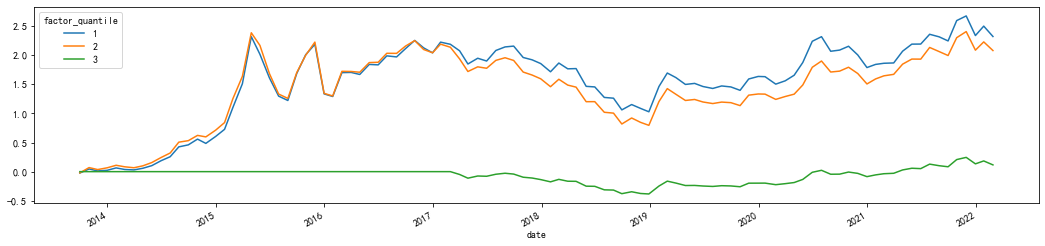

In [18]:
# 全样本
# 按观察结果排序后合成
score = comp_factor.factor_score_indicators(factors, 'maxicir_ledoit',
                                            factor_direction, 5)
group_df = add_group(score, 'score', 3)
score['factor_quantile'] = group_df['score']

group_ret = get_group_return(score, ['factor_quantile']).reset_index(level=0,
                                                                     drop=True)
group_cum = ep.cum_returns(group_ret)

group_cum.plot(figsize=(18, 4))


<AxesSubplot:xlabel='date'>

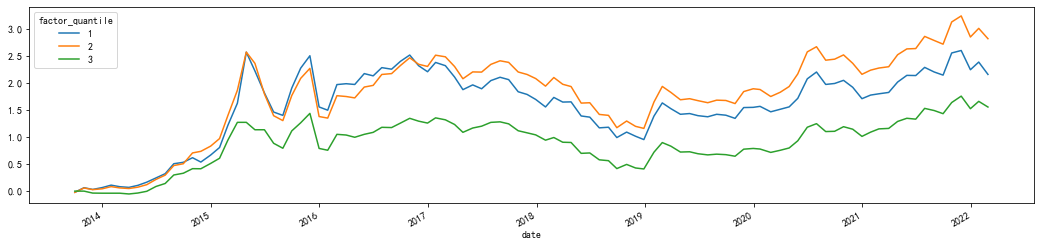

In [19]:
# 全样本
# 直接合成
score1 = comp_factor.fac_maxicir_ledoit(factors, 5)
group_df1 = add_group(score1, 'score', 3)
score1['factor_quantile'] = group_df1['score']
score1['next_ret'] = factors['next_ret']
group_ret1 = get_group_return(score1,
                              ['factor_quantile']).reset_index(level=0,
                                                               drop=True)
group_cum1 = ep.cum_returns(group_ret1)

group_cum1.plot(figsize=(18, 4))


<AxesSubplot:xlabel='date'>

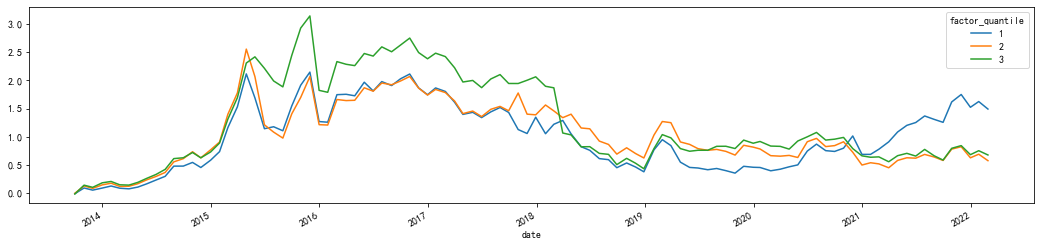

In [20]:
# 导入期
stack_quandrant = quandrant.stack().to_frame('cat_type')

quandrant1 = stack_quandrant.query('cat_type==2').index

quandrant_factor1 = factors.loc[quandrant1].copy()

score = comp_factor.factor_score_indicators(quandrant_factor1,
                                            'maxicir_ledoit', factor_direction,
                                            5)
group_df = add_group(score, 'score', 3)
score['factor_quantile'] = group_df['score']

group_ret = get_group_return(score, ['factor_quantile']).reset_index(level=0,
                                                                     drop=True)
group_cum = ep.cum_returns(group_ret)

group_cum.plot(figsize=(18, 4))


<AxesSubplot:xlabel='date'>

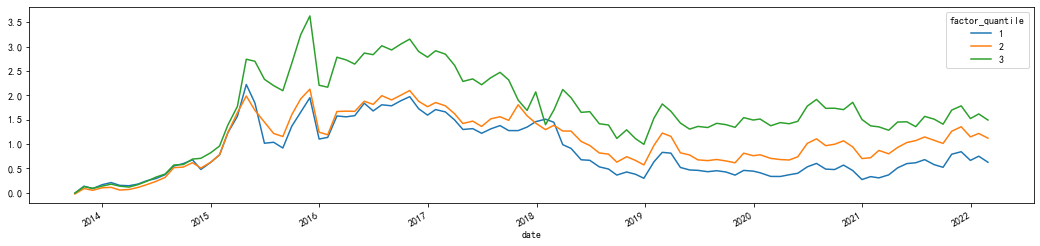

In [21]:
score1 = comp_factor.fac_maxicir_ledoit(quandrant_factor1, 5)
group_df1 = add_group(score1, 'score', 3)
score1['factor_quantile'] = group_df1['score']
score1['next_ret'] = quandrant_factor1['next_ret']
group_ret1 = get_group_return(score1,
                              ['factor_quantile']).reset_index(level=0,
                                                               drop=True)
group_cum1 = ep.cum_returns(group_ret1)

group_cum1.plot(figsize=(18, 4))
